# First Steps with TensorFlow

A collection of snippets I've made while playing with TF, inspired by the [Get Started](https://www.tensorflow.org/get_started/eager) guide.

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

## Balance Scale

The dataset I've picked is [Balance Scale Weight & Distance](http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale), with three distinct classes (left, right, balanced) and four numerical attributes (left weight, left distance, right weight, right distance). There are 625 instances in the dataset, 480 (~75%) of which are used for training, while the rest are test data.

In [2]:
dataset = "http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data"
tf_dataset = tf.keras.utils.get_file(fname='balance-scale', origin=dataset)

dataset_label_mapping = tf.contrib.lookup.HashTable(
  tf.contrib.lookup.KeyValueTensorInitializer(['L', 'B', 'R'], [0, 1, 2]), -1)

def parse_dataset_line(line):
    parsed_line = tf.decode_csv(line, [[''], [0.0], [0.0], [0.0], [0.0]])
    # The attributes form a single tensor of features
    features = tf.reshape(parsed_line[1:], shape=(4,))
    # String labels need to be converted to integers
    label = tf.reshape(dataset_label_mapping.lookup(parsed_line[0]), shape=())
    return features, label

parsed_dataset = tf.data.TextLineDataset(tf_dataset).map(parse_dataset_line)

train_dataset = parsed_dataset.take(480)
test_dataset = parsed_dataset.skip(480)

The network model features:
* 4 inputs
* a fully-connected (`Dense`) hidden layer with 6 nodes and a _rectified linear unit_ (ReLU), a unit that uses the _rectifier_ activation function, defined as $f(x) = max(0, x)$.
* a fully-connected output layer with 3 nodes (for each label) and a _softmax_ activation function, which highlights the largest inputs and suppresses those that are significantly below the maximum.

In [3]:
inputs = tf.keras.Input(shape=(4,))
hidden = tf.keras.layers.Dense(6, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(hidden)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

Cost (_loss_) functions are readily available in the library. I'll use [sparse_softmax_cross_entropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy), which accepts sparse (not [one-hot encoded](http://www.cs.toronto.edu/~guerzhoy/321/lec/W04/onehot.pdf)) integer labels. As the classes in the dataset are mutually exclusive, cross entropy can be used to measure dissimilarity between the true label and the predicted value.

In [4]:
def loss(model, inputs, target_outputs):
    actual_outputs = model(inputs)
    return tf.losses.sparse_softmax_cross_entropy(target_outputs, actual_outputs)

A [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) records computations -- in this case, the forward pass and the loss function evaluation -- and computes the gradient, differentiating input (`loss_value`) with respect to weights (`model.variables`).

In [5]:
def gradients(model, inputs, target_outputs):
    with tf.GradientTape() as g:
        loss_value = loss(model, inputs, target_outputs)
    return g.gradient(loss_value, model.variables)

We also need to choose [an implementation](https://www.tensorflow.org/api_guides/python/train) of the _gradient descent_ algorithm (called _optimizer_ in TensorFlow), of which several are available, e.g. stochastic gradient descent, [Adam](https://stats.stackexchange.com/a/220563), and so on:

In [6]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

The training loop iterates $N$ times over the entire training dataset (a single iteration is called an _epoch_), in batches of 32. There are built-in metrics (mean loss and accuracy) that can be plotted to visualize the training process.

In [7]:
loss_by_epoch = []
accuracy_by_epoch = []

N = 100
train_dataset = train_dataset.batch(32)

for epoch in range(N):
    epoch_loss = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    for inputs, outputs in train_dataset:
        grads = gradients(model, inputs, outputs)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        epoch_loss(loss(model, inputs, outputs))
        epoch_accuracy(tf.argmax(model(inputs), axis=1, output_type=tf.int32), outputs)

    loss_by_epoch.append(epoch_loss.result())
    accuracy_by_epoch.append(epoch_accuracy.result())
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, accuracy: {epoch_accuracy.result():.3f}')

Epoch 1, accuracy: 0.510
Epoch 10, accuracy: 0.575
Epoch 20, accuracy: 0.627
Epoch 30, accuracy: 0.696
Epoch 40, accuracy: 0.746
Epoch 50, accuracy: 0.790
Epoch 60, accuracy: 0.825
Epoch 70, accuracy: 0.848
Epoch 80, accuracy: 0.867
Epoch 90, accuracy: 0.867
Epoch 100, accuracy: 0.869


Let's plot the metrics:

<IPython.core.display.Javascript object>


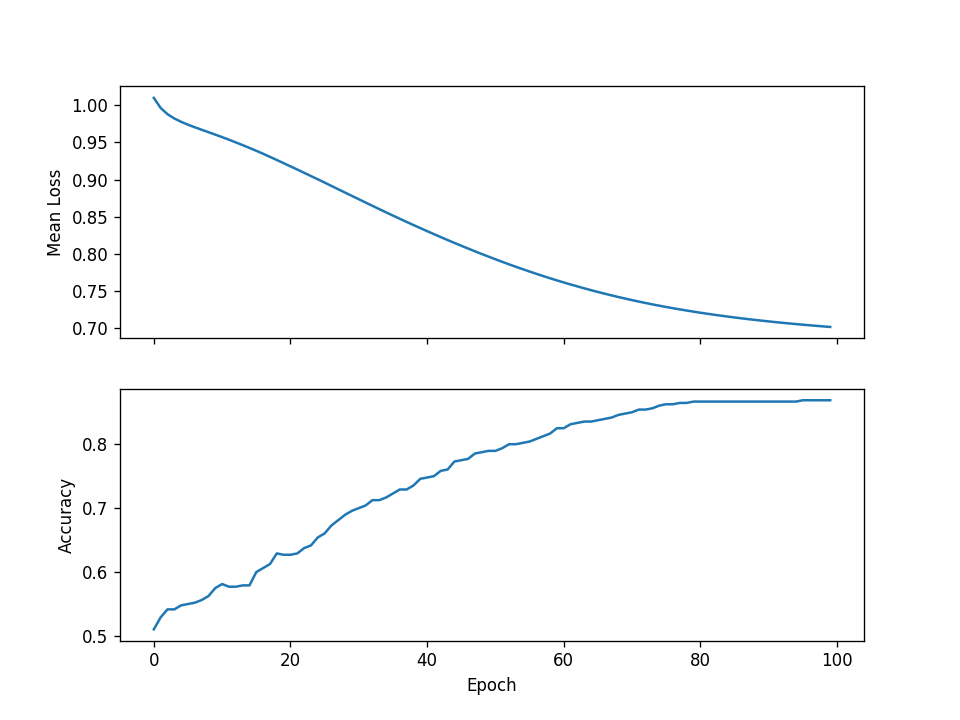

In [8]:
%matplotlib notebook

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(8, 6))

axes[0].set_ylabel('Mean Loss')
axes[0].plot(loss_by_epoch)

axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].plot(accuracy_by_epoch)

plt.show()

TensorFlow metrics can also be used to test the model, that is, evaluate its effectiveness on data that has not been presented during the training phase:

In [9]:
test_accuracy = tfe.metrics.Accuracy()

for inputs, target_outputs in test_dataset.batch(32):
    actual_outputs = tf.argmax(model(inputs), axis=1, output_type=tf.int32)
    test_accuracy(actual_outputs, target_outputs)

print(f'Test accuracy: {test_accuracy.result():.1%}')

Test accuracy: 91.0%
